In [1]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io

import ray

# install

mamba create -n SOPA3 python==3.10  
mamba activate SOPA3  
pip install 'sopa[snakemake,cellpose,baysor,tangram]'  
pip install napari-spatialdata spatialdata-plot jupyter ray pyqt5 loguru

In [2]:
path_to_image = "/Volumes/ag_coscia/Jose/P26_BCCN/P26E02_FrameSlides/991/qupath_8k_subset/991_subset.ome.tif"

In [23]:
sdata = sopa.io.ome_tif(path_to_image, as_image=False)
sdata

INFO     `dims` is specified redundantly: found also inside `data`.                                                


SpatialData object
└── Images
      └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images)

In [24]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1200, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 64 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((1200 0, 1200 1200, 0 1200, 0 0, 1200...","[0, 0, 1200, 1200]","[0, 0]"
1,"POLYGON ((2300 0, 2300 1200, 1100 1200, 1100 0...","[1100, 0, 2300, 1200]","[1, 0]"
2,"POLYGON ((3400 0, 3400 1200, 2200 1200, 2200 0...","[2200, 0, 3400, 1200]","[2, 0]"
3,"POLYGON ((4500 0, 4500 1200, 3300 1200, 3300 0...","[3300, 0, 4500, 1200]","[3, 0]"
4,"POLYGON ((5600 0, 5600 1200, 4400 1200, 4400 0...","[4400, 0, 5600, 1200]","[4, 0]"
...,...,...,...
59,"POLYGON ((4500 7700, 4500 8900, 3300 8900, 330...","[3300, 7700, 4500, 8900]","[3, 7]"
60,"POLYGON ((5600 7700, 5600 8900, 4400 8900, 440...","[4400, 7700, 5600, 8900]","[4, 7]"
61,"POLYGON ((6700 7700, 6700 8900, 5500 8900, 550...","[5500, 7700, 6700, 8900]","[5, 7]"
62,"POLYGON ((7800 7700, 7800 8900, 6600 8900, 660...","[6600, 7700, 7800, 8900]","[6, 7]"


In [25]:
from sopa._sdata import get_spatial_image
print(get_spatial_image(sdata=sdata).c.values)

['750_bg' '647_bg' '555_bg' '488_bg' 'DAPI_bg' 'Vimentin' 'CD3e' 'panCK'
 'CD8' 'DAPI_1' 'COL1A1' 'CD20' 'CD68' 'Ki67' 'DAPI_2']


In [27]:
channels = ["DAPI_1"]
# nuclear segmentation

In [28]:
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=0.4, cellprob_threshold=0, model_type="nuclei")
#diameter observed in qupath, cellpose defaults for the other parameters

In [29]:
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)

In [30]:
# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991_subset.zarr/.sopa_cache/cellpose"

In [33]:
#parallelize the segmentation
ray.init()

@ray.remote
def process_patch(cellpose_temp_dir, patch_index):
    segmentation.write_patch_cells(cellpose_temp_dir, patch_index)

2024-07-09 17:11:05,464	INFO worker.py:1771 -- Started a local Ray instance.


In [34]:
patches = range(len(sdata['sopa_patches']))
futures = [process_patch.remote(cellpose_temp_dir, patch_index) for patch_index in patches]

(raylet) Warning: The remote function __main__.process_patch is very large (25 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [35]:
ray.get(futures)
ray.shutdown()

(process_patch pid=44922) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=44927) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=44921) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=44924) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts) [repeated 8x across cluster]
(process_patch pid=44931) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts) [repeated 4x across cluster]
(process_patch pid=44930) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=44927) [INFO] (sopa.segmentation.shapes) Percentage of non-geomet

(process_patch pid=44930) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.13% (usually due to segmentation artefacts)


In [36]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)

Reading patches: 100%|██████████| 64/64 [00:00<00:00, 544.68it/s]
[INFO] (sopa.segmentation.stainings) Found 23 total cells


In [ ]:
# something did not work here, on the first SOPA run we had 2153 and we were undersegmenting

In [37]:
cells = sopa.segmentation.shapes.solve_conflicts(cells)

Resolving conflicts: 100%|██████████| 4/4 [00:00<00:00, 965.21it/s]


In [38]:
shapes_key = "cellpose_boundaries"
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key="991_subset", shapes_key=shapes_key)

[INFO] (sopa.segmentation.stainings) Added 21 cell boundaries in sdata['cellpose_boundaries']


In [39]:
sdata

SpatialData object
├── Images
│     └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (21, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), cellpose_boundaries (Shapes), sopa_patches (Shapes)

In [21]:
sdata.write("/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr", overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr                                                     


In [49]:
napari_spatialdata.Interactive(sdata)

2024-07-09 17:37:39.044 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-09 17:37:39.045 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.


In [ ]:
# overlap too small



# try again with different name

In [41]:
method_2 = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=2, cellprob_threshold=-6, model_type="nuclei")

In [42]:
segmentation_2 = sopa.segmentation.StainingSegmentation(sdata, method_2, channels, min_area=1000)

In [43]:
cellpose_temp_dir_2 = "tuto_2.zarr/.sopa_cache/cellpose"

In [44]:
segmentation_2.write_patches_cells(cellpose_temp_dir_2)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 64/64 [07:54<00:00,  7.42s/it]


In [47]:
cells_3 = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir_2)
cells_3 = sopa.segmentation.shapes.solve_conflicts(cells_3)

Reading patches: 100%|██████████| 64/64 [00:00<00:00, 383.79it/s]
[INFO] (sopa.segmentation.stainings) Found 11989 total cells
Resolving conflicts: 100%|██████████| 4594/4594 [00:00<00:00, 7672.59it/s]


In [48]:
shapes_key_2 = "cellpose_boundaries_2"
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells_3, image_key="991_subset", shapes_key=shapes_key_2)

/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries_2` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.segmentation.stainings) Added 10545 cell boundaries in sdata['cellpose_boundaries_2']


In [50]:
method_3 = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=2, cellprob_threshold=-6, model_type="nuclei")
segmentation_3 = sopa.segmentation.StainingSegmentation(sdata, method_3, channels, min_area=1000)
cellpose_temp_dir_3 = "tuto_3.zarr/.sopa_cache/cellpose"
ray.init()
patches = range(len(sdata['sopa_patches']))
futures = [process_patch.remote(cellpose_temp_dir_3, patch_index) for patch_index in patches]
ray.get(futures)
ray.shutdown()
cells_3 = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir_3)
cells_3 = sopa.segmentation.shapes.solve_conflicts(cells_3)
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells_3, image_key="991_subset", shapes_key="cellpose_boundaries_3")

2024-07-09 17:41:56,085	INFO worker.py:1771 -- Started a local Ray instance.


(raylet) Warning: The remote function __main__.process_patch is very large (28 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(process_patch pid=54715) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=54719) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=54718) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=54725) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts) [repeated 10x across cluster]
(process_patch pid=54720) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts) [repeated 2x across cluster]
(process_patch pid=54719) [INFO] (sopa.segmentation.shapes) Percentage of non-geometrized cells: 0.00% (usually due to segmentation artefacts)
(process_patch pid=54722) [INFO] (sopa.segmentation.shapes) Percentage of non-geome

ok, from this I learn that ray parallelization does not work, not sure I am implementing it right

In [51]:
# lets try to run 5 different cellposes with different parameters and store them in the SpatialData object

flow_thresholds = [2,4]
cellprob_thresholds = [-4, -6]

for i, (flow_threshold, cellprob_threshold) in enumerate(zip(flow_thresholds, cellprob_thresholds)):
    method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=channels, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold, model_type="nuclei")
    segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=300)
    cellpose_temp_dir = f"tuto_{i}.zarr/.sopa_cache/cellpose"
    segmentation.write_patches_cells(cellpose_temp_dir)
    
    cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
    cells = sopa.segmentation.shapes.solve_conflicts(cells)
    sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key="991_subset", shapes_key=f"cellpose_boundaries_FT{flow_threshold}_CT{cellprob_threshold}")

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 414.14it/s]
[INFO] (sopa.segmentation.stainings) Found 31229 total cells
Resolving conflicts: 100%|██████████| 19202/19202 [00:02<00:00, 7299.86it/s]
[INFO] (sopa.segmentation.stainings) Added 25985 cell boundaries in sdata['cellpose_boundaries_FT2_CT-4']
[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 64/64 [00:00<00:00, 480.98it/s]
[INFO] (sopa.segmentation.stainings) Found 31800 total cells
Resolving conflicts: 100%|██████████| 20328/20328 [00:02<00:00, 7441.71it/s]
[INFO] (sopa.segme

In [52]:
sdata

SpatialData object
├── Images
│     └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (21, 1) (2D shapes)
      ├── 'cellpose_boundaries_2': GeoDataFrame shape: (10545, 1) (2D shapes)
      ├── 'cellpose_boundaries_3': GeoDataFrame shape: (21, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT2_CT-4': GeoDataFrame shape: (25985, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT4_CT-6': GeoDataFrame shape: (26395, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), cellpose_boundaries (Shapes), cellpose_boundaries_2 (Shapes), cellpose_boundaries_3 (Shapes), cellpose_boundaries_FT2_CT-4 (Shapes), cellpose_boundaries_FT4_CT-6 (Shapes), sopa_patches (Shapes)

In [53]:
napari_spatialdata.Interactive(sdata)

2024-07-09 19:15:45.453 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-09 19:15:45.454 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-09 19:23:30.854 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-09 19:23:30.858 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.


In [54]:
sdata.write("/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr", overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr                                                     


In [2]:
sdata = spatialdata.read_zarr("/Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr")

In [5]:
napari_spatialdata.Interactive(sdata)

2024-07-10 10:24:30.052 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:24:30.053 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:27:23.480 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:27:23.482 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:09.656 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:09.657 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:32.378 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:32.379 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:44.694 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-10 10:28:44.694 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updati

In [3]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/20240709_991.zarr
├── Images
│     └── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (21, 1) (2D shapes)
      ├── 'cellpose_boundaries_2': GeoDataFrame shape: (10545, 1) (2D shapes)
      ├── 'cellpose_boundaries_3': GeoDataFrame shape: (21, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT2_CT-4': GeoDataFrame shape: (25985, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT4_CT-6': GeoDataFrame shape: (26395, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 1) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), cellpose_boundaries (Shapes), cellpose_boundaries_2 (Shapes), cellpose_boundaries_3 (Shapes), cellpose_boundaries_FT2_CT-4 (Shapes), cellpose_boundaries_FT4_CT-6 (Shapes), sopa_patches (Shapes)

In [9]:
bb_xmin = 2000
bb_ymin = 2000
bb_w = 1000
bb_h = 1000
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

cropped_sdata = sdata.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="pixels"
)

cropped_sdata

SpatialData object
├── Images
│     └── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
└── Shapes
      ├── 'cellpose_boundaries_2': GeoDataFrame shape: (259, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT2_CT-4': GeoDataFrame shape: (433, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT4_CT-6': GeoDataFrame shape: (442, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (4, 1) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), cellpose_boundaries_2 (Shapes), cellpose_boundaries_FT2_CT-4 (Shapes), cellpose_boundaries_FT4_CT-6 (Shapes), sopa_patches (Shapes)

In [ ]:
render_shapes(element=None, color=None, fill_alpha=1.0, groups=None, palette=None, 
            na_color='lightgrey', outline=False, outline_width=1.5, outline_color='#000000ff', 
            outline_alpha=1.0, cmap=None, norm=False, scale=1.0, table_name=None, **kwargs)

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.6705882352941175].


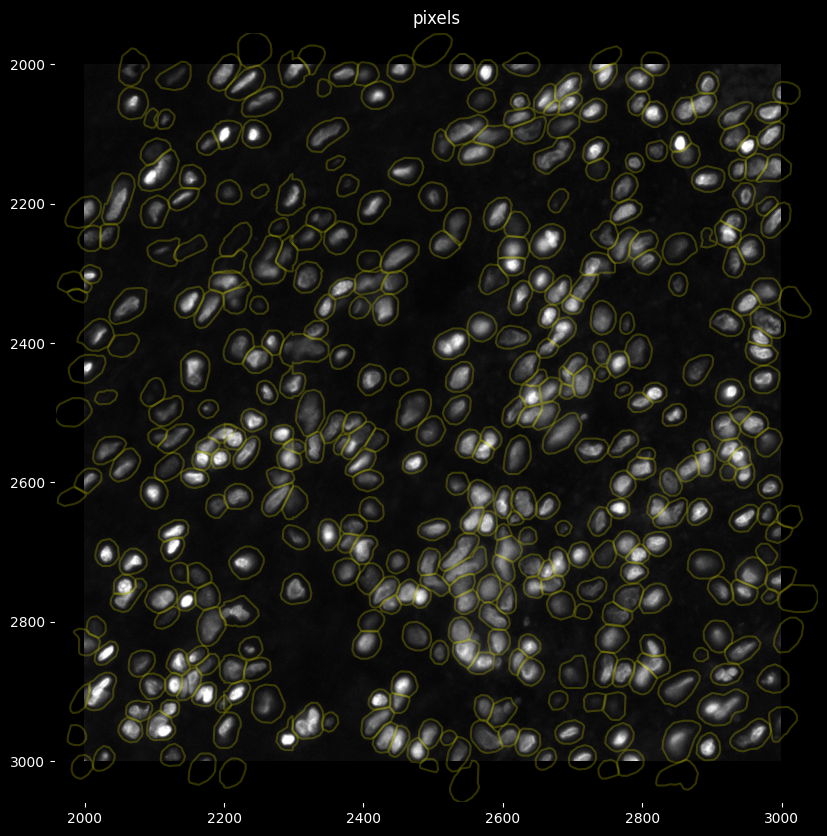

In [31]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
# Set the figure background color
f.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

cropped_sdata.pl.render_shapes(element="cellpose_boundaries_FT2_CT-4", color="red", fill_alpha=0.0, outline=True, outline_width=1.5, outline_color="yellow", outline_alpha=0.2).pl.show(ax=ax)
cropped_sdata.pl.render_images(element="991_subset", channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax)

In [33]:
cropped_sdata

SpatialData object
├── Images
│     └── '991_subset': DataTree[cyx] (15, 1000, 1000), (15, 500, 500), (15, 250, 250), (15, 125, 125), (15, 63, 63)
└── Shapes
      ├── 'cellpose_boundaries_2': GeoDataFrame shape: (259, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT2_CT-4': GeoDataFrame shape: (433, 1) (2D shapes)
      ├── 'cellpose_boundaries_FT4_CT-6': GeoDataFrame shape: (442, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (4, 1) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), cellpose_boundaries_2 (Shapes), cellpose_boundaries_FT2_CT-4 (Shapes), cellpose_boundaries_FT4_CT-6 (Shapes), sopa_patches (Shapes)

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.6705882352941175].


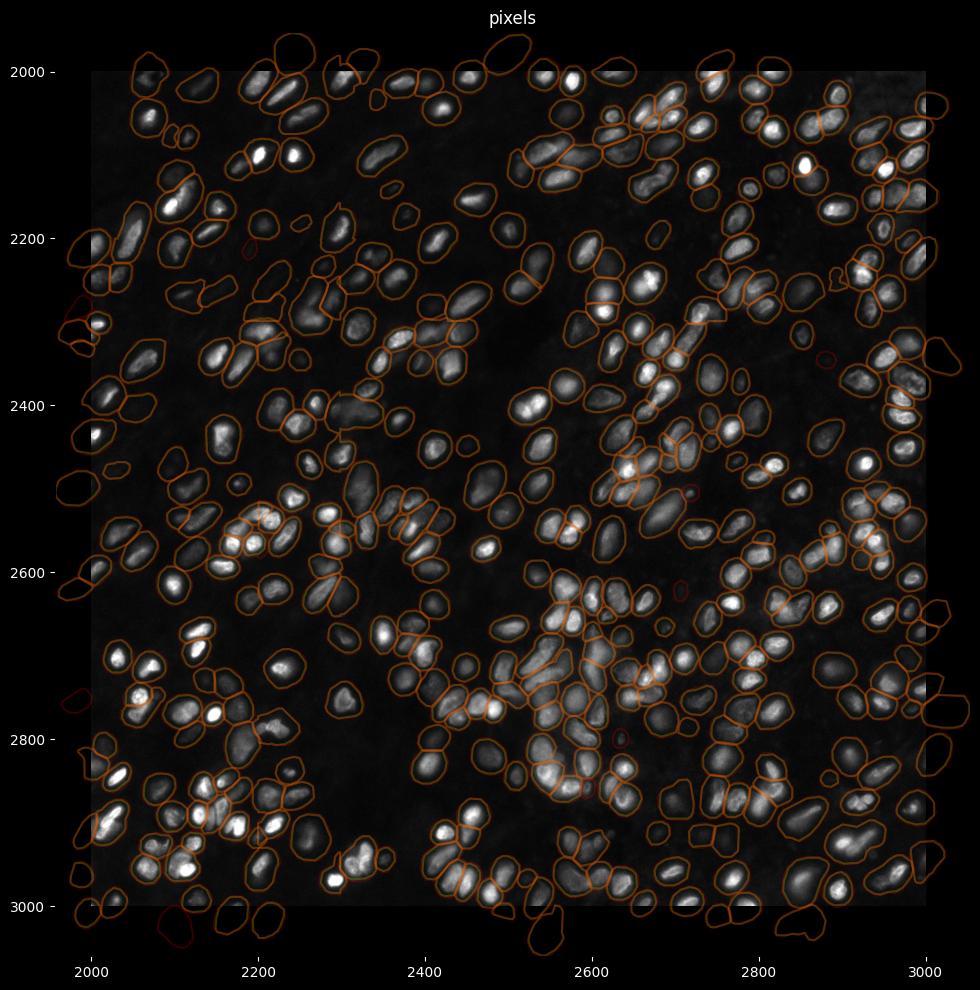

In [35]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 12))
# Set the figure background color
f.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

cropped_sdata.pl.render_shapes(element="cellpose_boundaries_FT2_CT-4", outline=True, outline_width=1.5, outline_color="yellow", outline_alpha=0.2).pl.show(ax=ax)
cropped_sdata.pl.render_shapes(element="cellpose_boundaries_FT4_CT-6", outline=True, outline_width=1.5, outline_color="red", outline_alpha=0.2).pl.show(ax=ax)
cropped_sdata.pl.render_images(element="991_subset", channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax)